In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [175]:
request_data = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/sample-hourly-request-rate.csv')

# Understanding the data

In [176]:
request_data.tail()

,Time,Point
667,5/6/21 14:00,640.439444
668,5/6/21 15:00,697.596944
669,5/6/21 16:00,647.408889
670,5/6/21 17:00,695.330556
671,5/6/21 18:00,675.820588


In [177]:
#convert type to datetime
request_data['Time'] = pd.to_datetime(request_data["Time"])

#For Prophet the time columns must be called ds and value as y
#note creating copy as going to set orginal Time as index
request_data['ds'] = request_data['Time']
request_data.rename(columns={'Point': 'y'}, inplace=True)

#set index as time for the series
request_data = request_data.set_index('Time')

In [178]:
request_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2021-04-08 19:00:00 to 2021-05-06 18:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       672 non-null    float64       
 1   ds      672 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


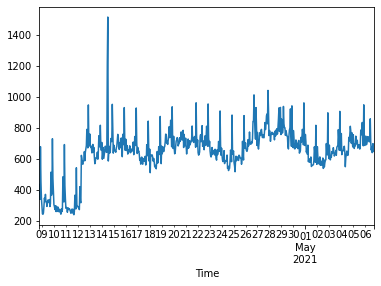

In [179]:
# plot everything
request_data['y'].plot()

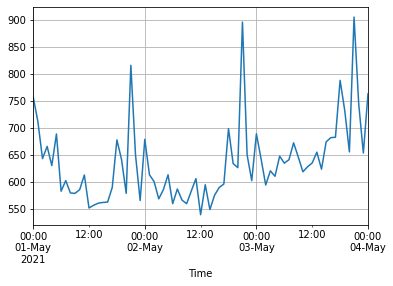

In [180]:
# view a subset of the data to zoom in
start_time = datetime(2021,5,1)
end_time = datetime(2021,5,4)

#subset of data
subset_request_data = request_data[(request_data.index >=start_time) & (request_data.index <= end_time)]
subset_request_data['y'].plot(grid=True)

# Stationarity

In [181]:
# show daily and weekly boxplot
df = pd.DataFrame(request_data)

df['week'] = [d.week for d in df.index]
df['day'] = [d.day for d in df.index]

#df.head()

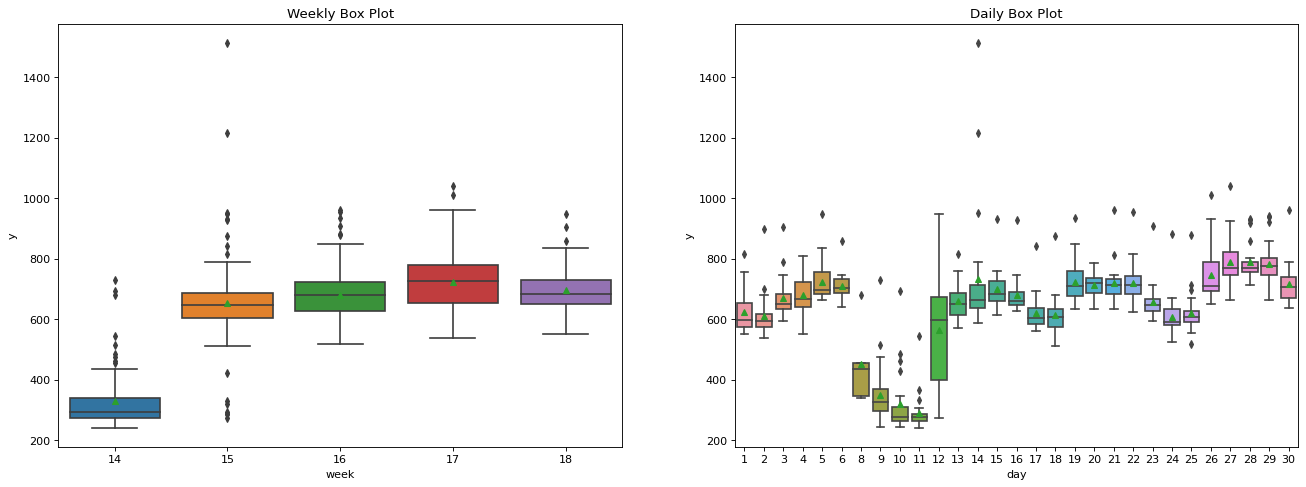

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='week', y='y', data=request_data, ax=axes[0], showmeans=True)
sns.boxplot(x='day', y='y', data=request_data, showmeans=True)

axes[0].set_title('Weekly Box Plot'); 
axes[1].set_title('Daily Box Plot')
plt.show()

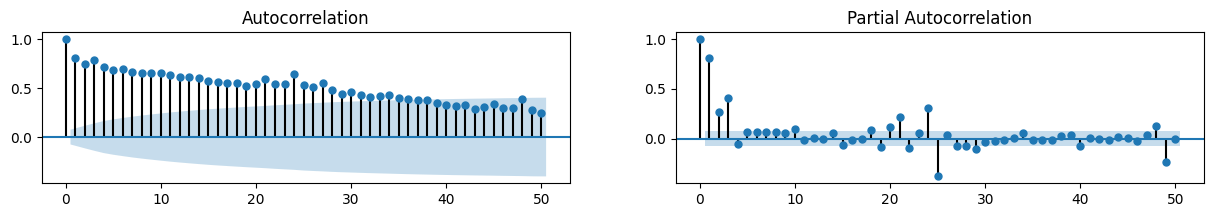

In [183]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(15,2), dpi= 100)
plot_acf(request_data.y.tolist(), lags=50, ax=axes[0]);
plot_pacf(request_data.y, lags=50, ax=axes[1]);

# Additive decompose

In [184]:
decomposition_a = sm.tsa.seasonal_decompose(request_data['y'], model='additive')
#decomposition_a_subset = sm.tsa.seasonal_decompose(subset_request_data['y'], model='additive')

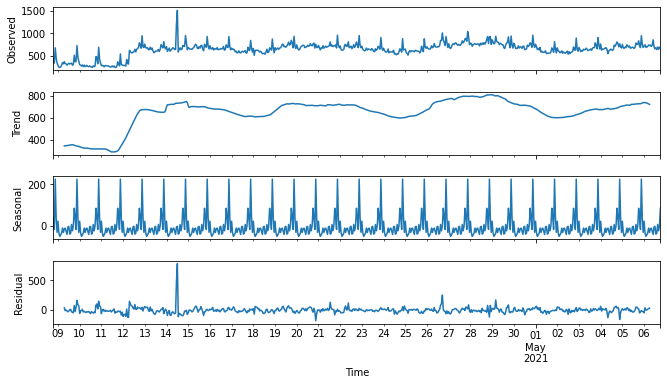

In [185]:
fig = decomposition_a.plot()
fig.set_size_inches(10,6)

#Multiplicative decompose

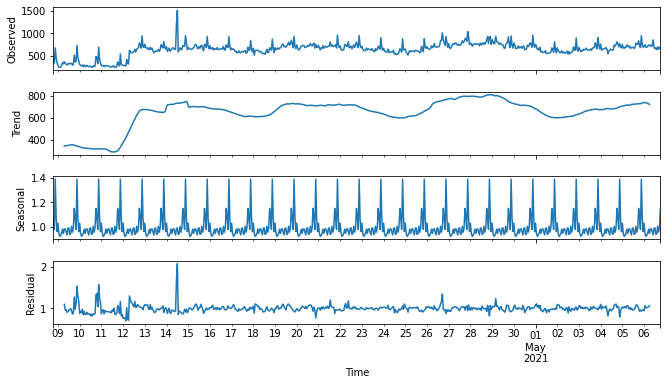

In [186]:
decomposition_m = sm.tsa.seasonal_decompose(request_data['y'], model='multiplicative')
fig = decomposition_m.plot()
fig.set_size_inches(10,6)

#Comparing additive and multiplicative

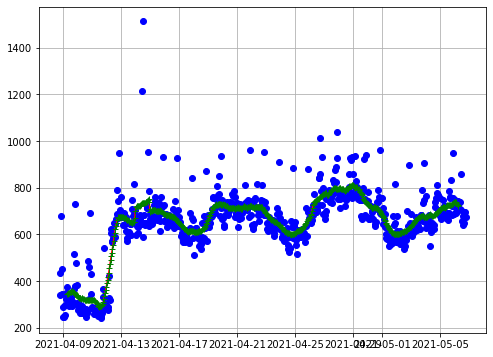

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.grid(True)
plt.plot(request_data.index, request_data['y'], 'bo', c='blue')
plt.plot(decomposition_a.trend.index, decomposition_a.trend, c='red')
plt.plot(decomposition_m.trend.index, decomposition_m.trend, 'r+', c='green')

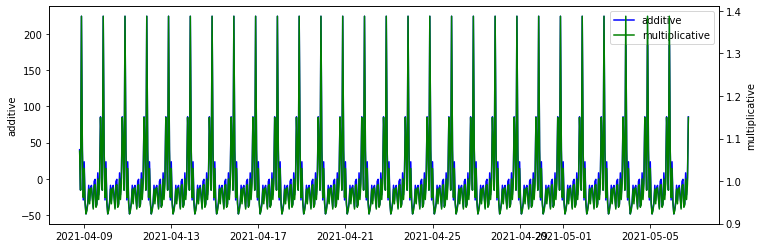

In [188]:
fig = plt.figure()
fig.set_size_inches(12, 4)

ax1 = fig.add_subplot()
ax1.set_ylabel('additive')
line1 = ax1.plot(decomposition_a.seasonal.index, decomposition_a.seasonal, c='blue', label='additive')

ax2 = ax1.twinx()  
ax2.set_ylabel('multiplicative')
line2 = ax2.plot(decomposition_m.seasonal.index, decomposition_m.seasonal, c='green', label='multiplicative')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

#Load observed future data
Loading next set of 7day data (7*24 rows)
Comparing this with forecast.

In [189]:
request_data_future = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/test-hourly-request-rate.csv')
print(request_data_future.shape)
request_data_future.tail()

(168, 2)


,Time,Point
163,5/13/21 14:00,856.887222
164,5/13/21 15:00,717.899167
165,5/13/21 16:00,709.526389
166,5/13/21 17:00,737.645278
167,5/13/21 18:00,855.658056


In [190]:
request_data_future['ds'] = request_data_future['Time']
#convert type to datetime
request_data_future['ds'] = pd.to_datetime(request_data_future['ds'])

request_data_future = request_data_future.set_index('Time')
request_data_future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 5/6/21 19:00 to 5/13/21 18:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Point   168 non-null    float64       
 1   ds      168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9+ KB


In [191]:
#compare forecast with 7day future
def compare_future(forecast, title):
  forecast_tail = forecast.tail(7*24)
  fig, ax = plt.subplots()
  fig.set_size_inches(15,4)
  ax.fill_between(forecast_tail.ds, forecast_tail['yhat_lower'], forecast_tail['yhat_upper'], alpha=0.2)
  line1 = plt.plot(forecast_tail.ds, forecast_tail['yhat'], c='blue', label='forecast')
  line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

  lines = line1+line2
  labels = [l.get_label() for l in lines]
  ax.legend(lines, labels, loc=0)

  plt.title(title)

# FB prophet additive

In [192]:
#default is additive but using param anyway, increasing default confidience interval from .8 to .95
fb_additive = Prophet(seasonality_mode='additive', interval_width=0.95)
fb_additive.fit(request_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [193]:
# adding 7 days forcast to data frame. note data is hourly so adding 7*24 periods
future_dates_additive = fb_additive.make_future_dataframe(periods=7*24, freq='H')
future_dates_additive.tail()

,ds
835,2021-05-13 14:00:00
836,2021-05-13 15:00:00
837,2021-05-13 16:00:00
838,2021-05-13 17:00:00
839,2021-05-13 18:00:00


In [194]:
forecast_additive = fb_additive.predict(future_dates_additive)
forecast_additive.tail()
# yhat is the the predicted value and lower/upper is the predicted range
# note predicted values of componets as well

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
835,2021-05-13 14:00:00,563.593664,410.912676,756.865037,479.479988,660.849540,23.656876,23.656876,23.656876,-21.630184,-21.630184,-21.630184,45.287060,45.287060,45.287060,0.0,0.0,0.0,587.250541
836,2021-05-13 15:00:00,563.123489,423.816978,760.882644,478.312103,661.136532,26.815870,26.815870,26.815870,-14.966736,-14.966736,-14.966736,41.782606,41.782606,41.782606,0.0,0.0,0.0,589.939359
837,2021-05-13 16:00:00,562.653313,429.113280,781.536625,476.946416,661.423525,33.169116,33.169116,33.169116,-5.061817,-5.061817,-5.061817,38.230932,38.230932,38.230932,0.0,0.0,0.0,595.822429
838,2021-05-13 17:00:00,562.183137,439.136905,776.419667,475.580728,661.710518,44.273934,44.273934,44.273934,9.617733,9.617733,9.617733,34.656201,34.656201,34.656201,0.0,0.0,0.0,606.457071
839,2021-05-13 18:00:00,561.712962,447.220077,811.197688,474.215041,661.997510,62.793047,62.793047,62.793047,31.711080,31.711080,31.711080,31.081966,31.081966,31.081966,0.0,0.0,0.0,624.506008


In [195]:
forecast_additive[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
835,2021-05-13 14:00:00,587.250541,410.912676,756.865037
836,2021-05-13 15:00:00,589.939359,423.816978,760.882644
837,2021-05-13 16:00:00,595.822429,429.113280,781.536625
838,2021-05-13 17:00:00,606.457071,439.136905,776.419667
839,2021-05-13 18:00:00,624.506008,447.220077,811.197688


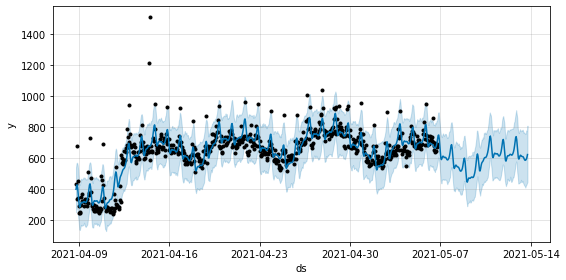

In [196]:
fb_additive.plot(forecast_additive, uncertainty=True, figsize=(8,4));
#black dots are actual, blue line is from model

In [197]:
#an interactive plot with plotly instead 
plot_plotly(fb_additive, forecast_additive)

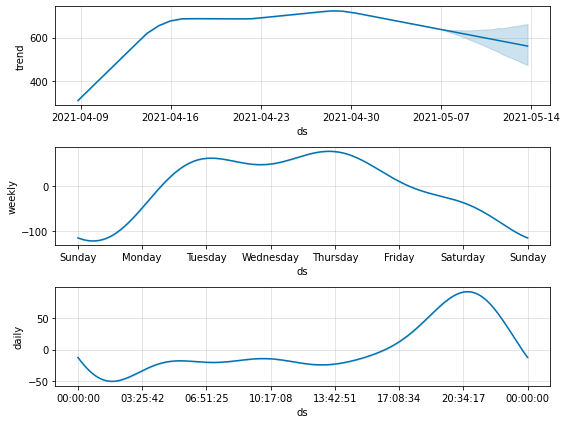

In [198]:
fb_additive.plot_components(forecast_additive, figsize=(8,6));

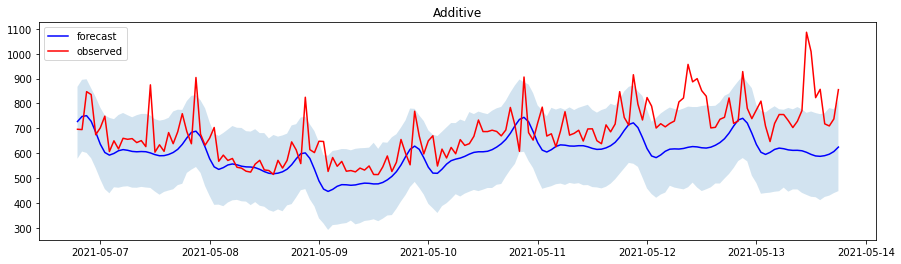

In [199]:
compare_future(forecast_additive, 'Additive')

# FB prophet mutliplicative

In [200]:
fb_multi = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
fb_multi.fit(request_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [201]:
future_dates_multi = fb_multi.make_future_dataframe(periods=7*24, freq='H')
forecast_multi = fb_multi.predict(future_dates_multi)
forecast_multi.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
835,2021-05-13 14:00:00,568.365873,410.823512,759.824531,463.943312,667.514545,-0.032879,-0.032879,-0.032879,0.031903,0.031903,0.031903,0.064782,0.064782,0.064782,0.0,0.0,0.0,586.498232
836,2021-05-13 15:00:00,567.914652,421.801087,776.546412,462.321556,668.084440,-0.021613,-0.021613,-0.021613,0.038232,0.038232,0.038232,0.059845,0.059845,0.059845,0.0,0.0,0.0,589.627078
837,2021-05-13 16:00:00,567.463430,409.953927,777.919313,460.702997,668.654334,-0.005417,-0.005417,-0.005417,0.049436,0.049436,0.049436,0.054854,0.054854,0.054854,0.0,0.0,0.0,595.516719
838,2021-05-13 17:00:00,567.012209,414.623266,778.353138,459.441771,669.224229,0.016775,0.016775,0.016775,0.066616,0.066616,0.066616,0.049841,0.049841,0.049841,0.0,0.0,0.0,604.784522
839,2021-05-13 18:00:00,566.560988,442.375196,802.341736,458.217553,669.794124,0.048285,0.048285,0.048285,0.093124,0.093124,0.093124,0.044839,0.044839,0.044839,0.0,0.0,0.0,619.321331


In [202]:
plot_plotly(fb_multi, forecast_multi)

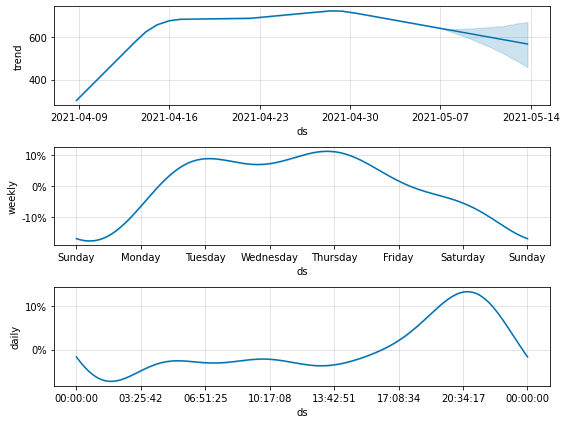

In [203]:
fb_multi.plot_components(forecast_multi, figsize=(8,6));

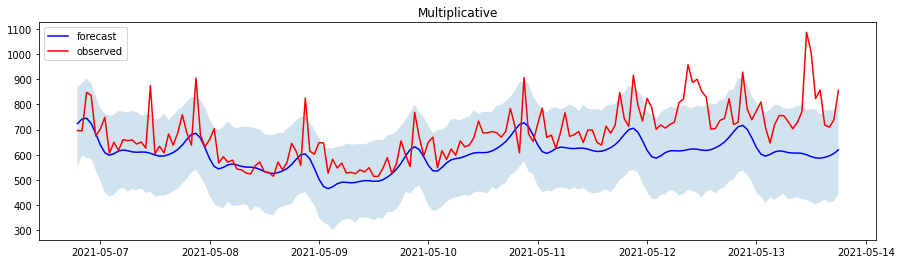

In [204]:
compare_future(forecast_multi, 'Multiplicative')